# QC pipeline on Frog #3

## Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

## Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_12148\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


## Basic QC workflow

In [3]:
adatas = []
data_names = ['control_lps','control_pic']
main_path = '/Code/data/single_cell/animals/frog/frog_3/control/'
paths =  ['\\control_lps','\\control_pic']
for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)  
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)

    reading \Code\data\single_cell\animals\frog\frog_3\control\control_lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.40 GB, difference +0.40 GB
(5010, 36854)
    reading \Code\data\single_cell\animals\frog\frog_3\control\control_pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.52 GB, difference +0.12 GB
(3986, 36854)


In [4]:
adata_control = adatas[0].concatenate(adatas[1], batch_categories=data_names, batch_key='treatment')

adata_control

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 8996 × 36854
    obs: 'treatment'
    var: 'gene_ids', 'feature_types'

In [5]:
adata_control.obs['treatment'] = 'control'
adata_control.obs

,treatment
AAACCCAAGAGCCGTA-1-control_lps,control
AAACCCAAGGTACCTT-1-control_lps,control
AAACCCACACCTATCC-1-control_lps,control
AAACCCACAGGGATAC-1-control_lps,control
AAACCCAGTAAGAACT-1-control_lps,control
...,...
TTTGTTGGTAGAGTTA-1-control_pic,control
TTTGTTGGTCGTGATT-1-control_pic,control
TTTGTTGTCGAGAATA-1-control_pic,control
TTTGTTGTCTCAATCT-1-control_pic,control


In [6]:
adata_control.obs.index = [x.split('-control')[0] for x in adata_control.obs.index]
adata_control.obs.index

Index(['AAACCCAAGAGCCGTA-1', 'AAACCCAAGGTACCTT-1', 'AAACCCACACCTATCC-1',
       'AAACCCACAGGGATAC-1', 'AAACCCAGTAAGAACT-1', 'AAACCCAGTATTTCCT-1',
       'AAACCCAGTCTAATCG-1', 'AAACCCAGTGGACCTC-1', 'AAACCCAGTTTCAGAC-1',
       'AAACCCATCGTTGTAG-1',
       ...
       'TTTGGTTTCAAGGACG-1', 'TTTGTTGCACAACATC-1', 'TTTGTTGCACCGTCTT-1',
       'TTTGTTGCATTGACTG-1', 'TTTGTTGGTAACGCGA-1', 'TTTGTTGGTAGAGTTA-1',
       'TTTGTTGGTCGTGATT-1', 'TTTGTTGTCGAGAATA-1', 'TTTGTTGTCTCAATCT-1',
       'TTTGTTGTCTCCAAGA-1'],
      dtype='object', length=8996)

In [7]:
adatas = [adata_control]
adata_control.obs_names_make_unique()

In [8]:
data_names = ['lps','pic']
main_path = '/Code/data/single_cell/animals/frog/frog_3/'
paths = ['\\lps','\\pic']
for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)
    sc.logging.print_memory_usage()
    print(adata_control.shape)
    adatas.append(adata_control)

    reading \Code\data\single_cell\animals\frog\frog_3\lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.68 GB, difference +0.16 GB
(8996, 36854)
    reading \Code\data\single_cell\animals\frog\frog_3\pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.74 GB, difference +0.06 GB
(8996, 36854)


In [ ]:
adata_control.obs

In [9]:
adata_all_treatments = adata_control.concatenate([adatas[1], adatas[2]], batch_key='treatment' , batch_categories = ['control', 'lps', 'pic'])
adata_all_treatments

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 26988 × 36854
    obs: 'treatment'
    var: 'gene_ids', 'feature_types'

In [10]:
adata_all_treatments.obs['treatment'] = adata_all_treatments.obs['treatment'].map({'control': 'control','lps': 'lps', 'pic': 'pic'})

In [11]:
adata_all_treatments.obs

,treatment
AAACCCAAGAGCCGTA-1-control,control
AAACCCAAGGTACCTT-1-control,control
AAACCCACACCTATCC-1-control,control
AAACCCACAGGGATAC-1-control,control
AAACCCAGTAAGAACT-1-control,control
...,...
TTTGTTGGTAGAGTTA-1-pic,pic
TTTGTTGGTCGTGATT-1-pic,pic
TTTGTTGTCGAGAATA-1-pic,pic
TTTGTTGTCTCAATCT-1-pic,pic


In [12]:
adata_all_treatments.var

,gene_ids,feature_types
ENSXLAG00005000039,ENSXLAG00005000039,Gene Expression
TPM2,ENSXLAG00005000040,Gene Expression
CA9,ENSXLAG00005000041,Gene Expression
TNFRSF8,ENSXLAG00005000042,Gene Expression
ENSXLAG00005000043,ENSXLAG00005000043,Gene Expression
...,...,...
ENSXLAG00005000037,ENSXLAG00005000037,Gene Expression
ENSXLAG00005000038,ENSXLAG00005000038,Gene Expression
ENSXLAG00005000121,ENSXLAG00005000121,Gene Expression
ENSXLAG00005010683,ENSXLAG00005010683,Gene Expression


In [ ]:
value_to_check = 'lps'

exists = value_to_check in adata_all_treatments.obs['treatment'].values

print(exists)

In [13]:
genes = pd.read_csv('/Code/data/single_cell/animals/frog/frog_annotations_trinotate.csv')
genes.dropna(subset = ['gene_id'], inplace=True)

genes_dict = dict(zip(genes['gene_id'].astype('str'), genes.eggnog_name.astype('str'))) #change the column name to fit the animal

dict_multi, dict_uni = {}, {}
for d in genes_dict:
    if len(d.split(',')) != 1:
        dict_multi[d] = genes_dict[d]
    else:
        dict_uni[d] =  genes_dict[d]

multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))

    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni, **multi_result_dict}

genes_dict

{'LOC121396124': 'ACSL5',
 'LOC121396047': 'V2R26',
 'hspa1a.S': 'HSP7C',
 'lin37.S': 'LIN37',
 'LOC108697211': 'PSD1',
 'LOC108697161': 'OR8H3',
 'hes3.S': 'HES3',
 'cox6b1.S': 'CX6B1',
 'LOC108703381': 'TIM23',
 'LOC108697459': 'IFIT5',
 'LOC108705111': 'CD22',
 'LOC108697170': 'OR5V1',
 'cblc.S': 'CBL',
 'tmem88.S': 'TMM88',
 'wapl.S': 'WAPL',
 'slk.S': 'SLK',
 'hes5.3.S': 'HES5',
 'LOC108697913': 'PKN2',
 'LOC121396138': 'TNIK',
 'LOC121396464': 'SCN2B',
 'ski.S': 'SKI',
 'zranb1.S': 'ZRN1B',
 'LOC108697264': 'DHDH',
 'masp2.S': 'MASP2',
 'clstn3.S': 'CSTN3',
 'LOC121396221': 'KPCD',
 'mcu.S': 'MCU',
 'LOC108697620': 'TNIK',
 'prxl2a.S': 'PXL2A',
 'emg1.S': 'NEP1',
 'LOC121396287': 'UN5BB',
 'tspan4.S': 'TSN4',
 'LOC108697505': 'ZSWM8',
 'mfsd13a.S': 'MF13A',
 'hes5.7.S': 'HES5',
 'LOC108697458': 'IFIT5',
 'LOC108697295': 'TMEM139',
 'uros.S': 'HEM4',
 'LOC108697935': 'AATC',
 'icmt.S': 'ICMT',
 'MGC154351': 'LAAT1',
 'bcl2l12.S': 'B2L12',
 'ndufa3.S': 'NDUA3',
 'kiaa2013.S': 'K201

In [ ]:
adata_all_treatments.obs

In [ ]:
adata_all_treatments.var

In [14]:
adata_all_treatments.var.set_index('gene_ids', inplace=True) 
adata_all_treatments.var['gene_ids'] = adata.var.index

adata_all_treatments.var.drop(columns='feature_types', inplace=True)
adata_all_treatments.var.rename(genes_dict, inplace=True)

In [15]:
# This code identifies duplicate variable names, iterates through them, and adds suffixes to make them unique from the first occurrence.
# Please make sure to replace adata with your actual AnnData object.

# Keep in mind that Scanpy's functionality may evolve, so it's a good idea to check the documentation or release notes
# for any updates related to making variable names unique starting from the first occurrence in more recent versions of Scanpy.

# Get a Series of variable (gene) names
var_names_series = pd.Series(adata_all_treatments.var_names)

# Identify duplicate variable names
duplicate_var_names = var_names_series[var_names_series.duplicated(keep='first')]

# Iterate through duplicates and add suffixes to make them unique from the first occurrence
for duplicate_name in duplicate_var_names:
    count = 1
    indices = var_names_series[var_names_series == duplicate_name].index
    for idx in indices:
        var_names_series[idx] = f'{duplicate_name}_{count}'
        count += 1

# Update the AnnData object with the unique variable names
adata_all_treatments.var_names = var_names_series.values

adata_all_treatments.var_names

Index(['ENSXLAG00005000039', 'ENSXLAG00005000040', 'ENSXLAG00005000041',
       'ENSXLAG00005000042', 'ENSXLAG00005000043', 'ENSXLAG00005000044',
       'ENSXLAG00005000045', 'ENSXLAG00005000046', 'ENSXLAG00005000047',
       'ENSXLAG00005000048',
       ...
       'ENSXLAG00005000032', 'ENSXLAG00005000033', 'ENSXLAG00005000034',
       'ENSXLAG00005000035', 'ENSXLAG00005000036', 'ENSXLAG00005000037',
       'ENSXLAG00005000038', 'ENSXLAG00005000121', 'ENSXLAG00005010683',
       'ENSXLAG00005000122'],
      dtype='object', length=36854)

## Genes and cells filtration 

normalizing counts per cell
    finished (0:00:00)


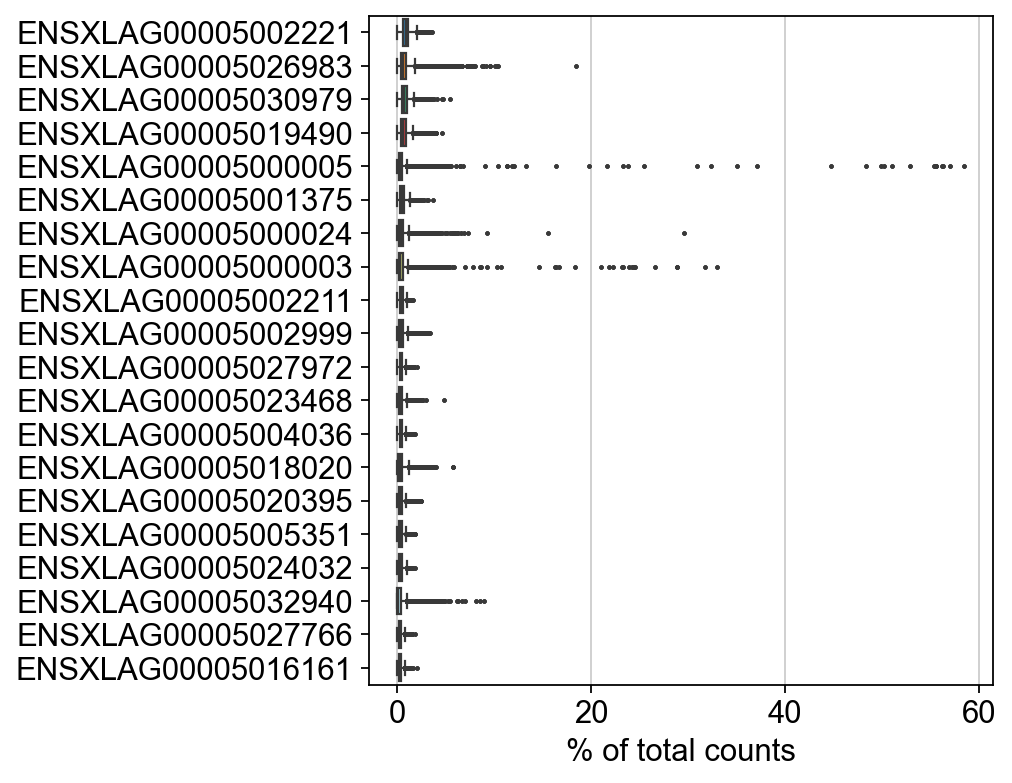

In [16]:
sc.pl.highest_expr_genes(adata_all_treatments, n_top=20)

In [17]:
sc.pp.filter_cells(adata_all_treatments, min_genes=100) 
sc.pp.filter_genes(adata_all_treatments, min_cells=3)
print(adata_all_treatments.shape) 

filtered out 36 cells that have less than 100 genes expressed
filtered out 11929 genes that are detected in less than 3 cells
(26952, 24925)


### Mitochondrial QC and general measures
Check if genes are annotated as mt by running:
- GENES= list(adata.var.index[adata.var.index.str.startswith('mt-'.upper())])
- GENES

In case the genes are not annotated as 'MT-'' (Like in bats), run:

- dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2'...etc}
- adata.var.rename(dict_replace, inplace = True)

In [18]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata_all_treatments.var.rename(dict_replace, inplace=True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [19]:
adata_all_treatments.var['MT'] = adata_all_treatments.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata_all_treatments, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [20]:
sc.pp.calculate_qc_metrics(adata_all_treatments, percent_top=None, log1p=False, inplace=True)

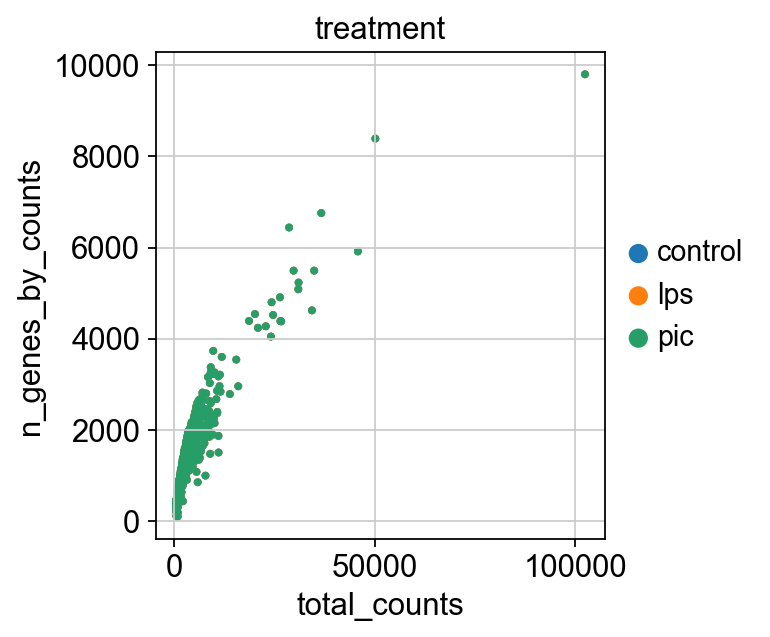

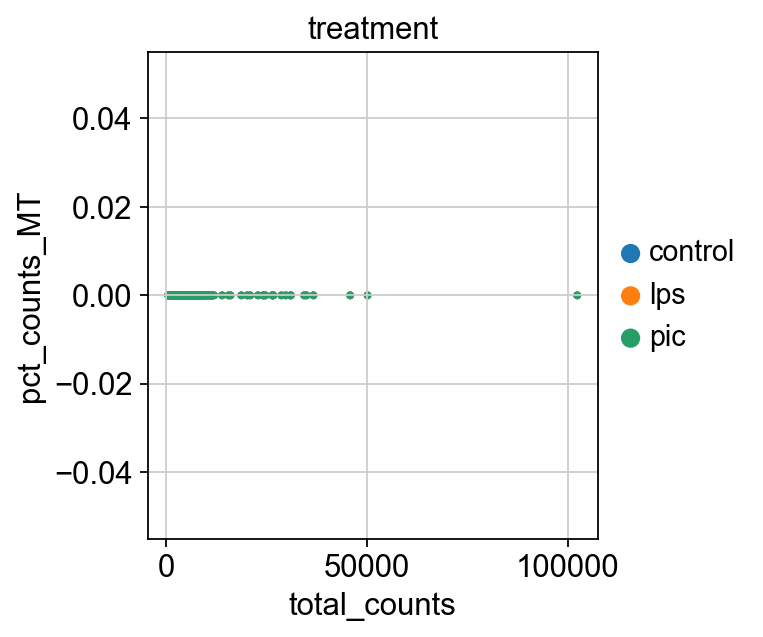

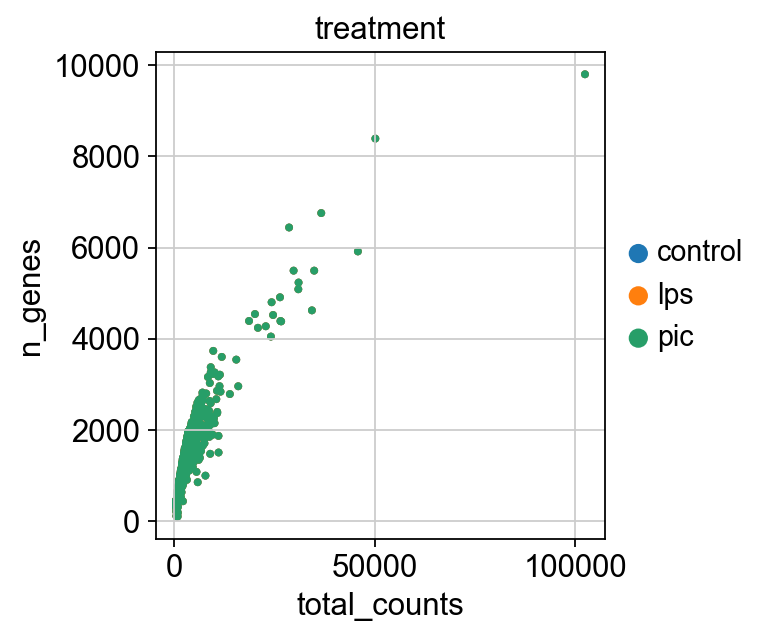

In [21]:
sc.pl.scatter(adata_all_treatments, x='total_counts', y='n_genes_by_counts', color='treatment', size=50)
sc.pl.scatter(adata_all_treatments, x='total_counts', y='pct_counts_MT', color='treatment', size=50)
sc.pl.scatter(adata_all_treatments, x='total_counts', y='n_genes', color='treatment', size=50)

In [22]:
adata_all_treatments = adata_all_treatments[adata_all_treatments.obs.pct_counts_MT < 20] 
adata_all_treatments = adata_all_treatments[adata_all_treatments.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

### Doublet analysis and filtering

In [23]:
import scrublet as scr

def scrub(adatas, adata_all_treatments, adata_all_treatments_names):  # based on raw individual samples. 
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data,name in zip(adatas, adata_all_treatments_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)

    adata_all_treatments = adata_all_treatments[adata_all_treatments.obs.index.isin(doub_index)]
    print('After scrublet: ', adata_all_treatments.shape[0])
    return adata_all_treatments

Before scrublet:  5218
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 17.7 seconds
Doubletslps : 836
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.4%
Elapsed time: 15.0 seconds
Doubletspic : 914
After scrublet:  15766


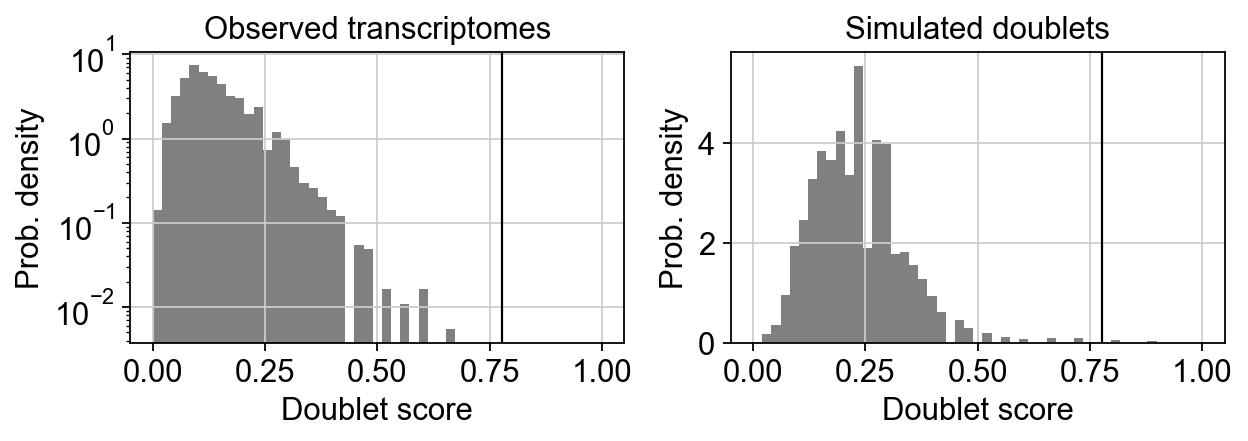

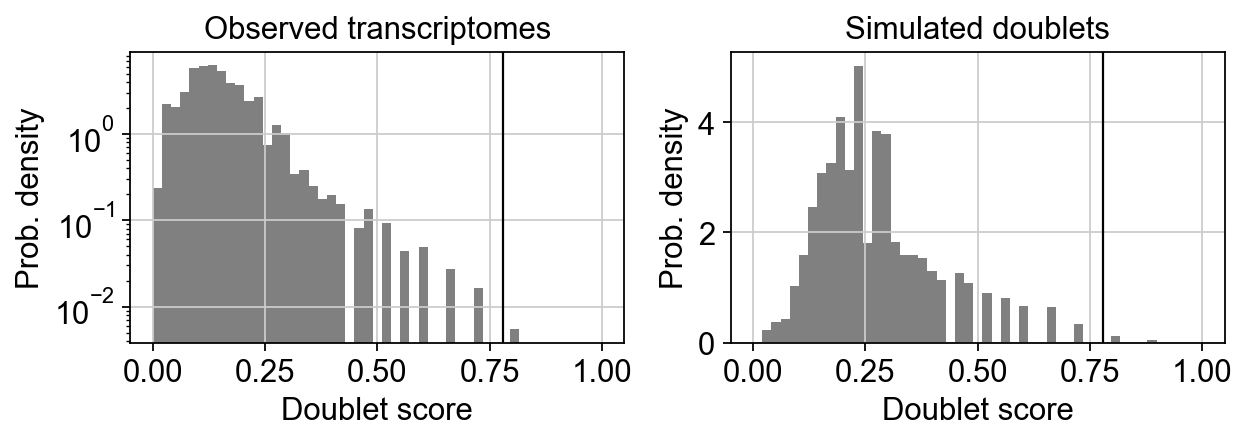

In [24]:
adata_all_treatments = scrub(adatas, adata_all_treatments, data_names)

### Cell cycle scoring
download Cell cycle txt: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt

In [25]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [26]:
adata.var_names

Index(['ENSXLAG00005000039', 'TPM2', 'CA9', 'TNFRSF8', 'ENSXLAG00005000043',
       'ENSXLAG00005000044', 'ENSXLAG00005000045', 'ENSXLAG00005000046',
       'ENSXLAG00005000047', 'ENSXLAG00005000048',
       ...
       'ENSXLAG00005000032', 'ND5-3', 'ND6', 'ENSXLAG00005000035', 'CYTB-1',
       'ENSXLAG00005000037', 'ENSXLAG00005000038', 'ENSXLAG00005000121',
       'ENSXLAG00005010683', 'ENSXLAG00005000122'],
      dtype='object', length=36854)

In [31]:
g2m_genes

['HMGB2',
 'CDK1',
 'BIRC5',
 'TPX2',
 'TOP2A',
 'NDC80',
 'CKS2',
 'TMPO',
 'CENPF',
 'TACC3',
 'SMC4',
 'CCNB2',
 'CKAP2L',
 'CKAP2',
 'AURKB',
 'BUB1',
 'KIF11',
 'ANP32E',
 'TUBB4B',
 'GTSE1',
 'KIF20B',
 'CDC20',
 'TTK',
 'KIF2C',
 'RANGAP1',
 'NCAPD2',
 'DLGAP5',
 'CDCA8',
 'ECT2',
 'KIF23',
 'HMMR',
 'AURKA',
 'ANLN',
 'LBR',
 'CKAP5',
 'CENPE',
 'CTCF',
 'NEK2',
 'G2E3',
 'GAS2L3',
 'CBX5',
 'CENPA']

In [32]:
matching_values = adata_all_treatments.var_names.isin(cell_cycle_genes)

matching_values

array([False, False, False, ..., False, False, False])

In [33]:
cell_cycle_adata = adata_all_treatments.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata_all_treatments.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata_all_treatments.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata_all_treatments.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
       'CDCA7', 'DTL', 'UHRF1', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1',
       'SLBP', 'CCNE2', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6',
       'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'CHAF1B',
       'BRIP1', 'E2F8'],
      dtype='object')


ValueError: No valid genes were passed for scoring.

In [34]:
adata_all_treatments

View of AnnData object with n_obs × n_vars = 15766 × 24925
    obs: 'treatment', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_ids', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'treatment_colors'

In [35]:
adata_all_treatments.var

,gene_ids,n_cells,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
ENSXLAG00005000039,ENSXLAG00005000039,6,False,6,0.000223,99.977738,6.0
ENSXLAG00005000040,TPM2,3,False,3,0.000557,99.988869,15.0
ENSXLAG00005000042,TNFRSF8,3,False,3,0.000111,99.988869,3.0
ENSXLAG00005000043,ENSXLAG00005000043,36,False,36,0.001336,99.866429,36.0
ENSXLAG00005000045,ENSXLAG00005000045,57,False,57,0.002115,99.788513,57.0
...,...,...,...,...,...,...,...
ENSXLAG00005000036,CYTB-1,24018,False,24018,3.545748,10.886020,95565.0
ENSXLAG00005000037,ENSXLAG00005000037,12,False,12,0.000557,99.955476,15.0
ENSXLAG00005000038,ENSXLAG00005000038,18,False,18,0.000668,99.933215,18.0
ENSXLAG00005000121,ENSXLAG00005000121,21,False,21,0.000779,99.922084,21.0


## Saving adata

In [ ]:
# adata.write(r'/Code/data/single_cell/animals/frog/frog_2/laevis/''frog_2_after_qc.h5ad')